In [111]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#### Logistic map function

In [ ]:
def logistic_map(x, a):
    return a * x * (1 - x)

#### Calculate actual values for the bifurcation diagram

In [114]:
def calculate_bifurcation_values(a_values: np.ndarray, x0: float, num_transient: int, num_collect: int):
    bifurcation_a, bifurcation_x = [], []
    for a in a_values:
        x = x0
        # Iterate until x should be stable
        for _ in range(num_transient):
            x = logistic_map(x, a)
        # Collect the seemingly stable values of x
        for _ in range(num_collect):
            x = logistic_map(x, a)
            bifurcation_a.append(a)
            bifurcation_x.append(x)
    return np.array(bifurcation_a), np.array(bifurcation_x)

In [115]:
a_values = np.linspace(1, 4.0, 1000)
bifurcation_a, bifurcation_x = calculate_bifurcation_values(a_values, 0.5, 250, 250)

#### Function to plot bifurcation diagram

In [169]:
def plot_bifurcation_diagram(
        a_vals_axis: np.ndarray, 
        bifurcation_a: np.ndarray, 
        bifurcation_x: np.ndarray, 
        title: str):
    plt.figure(figsize=(8, 5))
    plt.plot(bifurcation_a, bifurcation_x, ',k', alpha=0.1)
    plt.title(title)
    plt.xlabel("Parameter 'a'")
    plt.ylabel("Long-term values of x")
    if len(a_vals_axis) > 0:
      plt.xlim(a_vals_axis.min(), a_vals_axis.max())
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

#### Visualize bifurcation diagram for the actual values

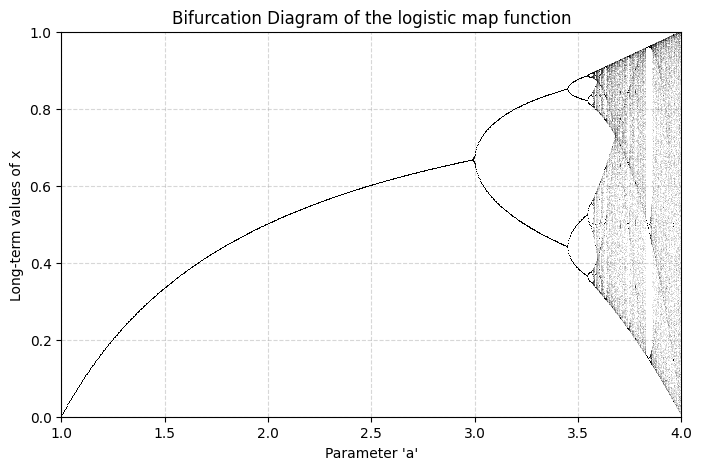

In [117]:
title = "Bifurcation Diagram for the logistic map function"
plot_bifurcation_diagram(a_values, bifurcation_a, bifurcation_x, title)

#### Definition of neural network to predict the logistic map function

In [119]:
class LogisticMapLearner(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 64)
        self.layer_2 = nn.Linear(64, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.output_layer(x)
        return x

#### Generate training data for the neural network

In [ ]:
def generate_training_data(num_samples: int, a_range: tuple, num_transient: int, num_collect: int):
    X_train_list, y_train_list = [], []
    a_samples = torch.rand(num_samples, device=device) * (a_range[1] - a_range[0]) + a_range[0]
    for a in a_samples:
        x = torch.rand(1, device=device)
        # Iterate until x should be stable
        for _ in range(num_transient):
            x = logistic_map(x, a)
        # Collect the seemingly stable values of x
        for _ in range(num_collect):
            x_n = x
            x_n_plus_1 = logistic_map(x_n, a)
            X_train_list.append(torch.stack([x_n.squeeze(), a.squeeze()]))
            y_train_list.append(x_n_plus_1)
            x = x_n_plus_1
    X_train = torch.stack(X_train_list).float()
    y_train = torch.stack(y_train_list).float()
    return X_train, y_train

In [160]:
X_train_map, y_train_map = generate_training_data(1000, (1.0, 4.0), 250, 250)
dataset_map = TensorDataset(X_train_map, y_train_map)
train_loader_map = DataLoader(dataset_map, batch_size=128, shuffle=True)

#### Train the neural netwrok

In [ ]:
def train_model(model: nn.Module, loader: DataLoader, optimizer, epochs: int):
    for _ in range(epochs):
        running_loss = 0.0
        for inputs, labels in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = nn.MSELoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

In [164]:
model = LogisticMapLearner().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader_map, optimizer, epochs=50)

#### Predict values for bifurcation diagram using the neural network

In [165]:
def predict_bifurcation_values(model, a_values: np.ndarray, x0: float, num_transient: int, num_collect: int):
    model.eval()
    bifurcation_a_nn, bifurcation_x_nn = [], []
    a_values_torch = torch.from_numpy(a_values.astype(np.float32)).to(device)
    for i, a in enumerate(a_values_torch):
        x = torch.tensor([x0], dtype=torch.float32, device=device)
        a_val = a.unsqueeze(0)
        with torch.no_grad():
            # Iterate until x should be stable using NN prediction
            for _ in range(num_transient):
                nn_input = torch.cat((x, a_val), dim=0).unsqueeze(0)
                x = model(nn_input).squeeze(0)
            # Collect the seemingly stable values of x using NN prediction
            for _ in range(num_collect):
                nn_input = torch.cat((x, a_val), dim=0).unsqueeze(0)
                x = model(nn_input).squeeze(0)
                bifurcation_a_nn.append(a.item())
                bifurcation_x_nn.append(np.clip(x.item(), 0.0, 1.0))
    return np.array(bifurcation_a_nn), np.array(bifurcation_x_nn)

In [166]:
bifurcation_a_nn, bifurcation_x_nn = predict_bifurcation_values(model, a_values, 0.5, 250, 250)

#### Visualize the predicted bifurcation diagram

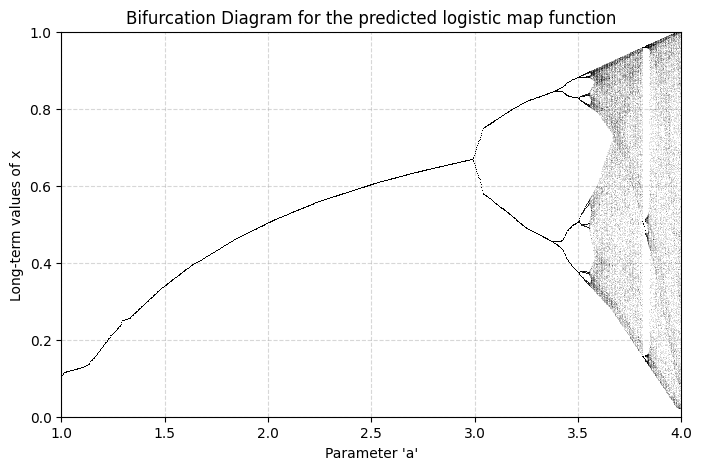

In [170]:
title = "Bifurcation Diagram for the predicted logistic map function"
plot_bifurcation_diagram(a_values, bifurcation_a_nn, bifurcation_x_nn, title)